In [34]:
# import stuff and define basic functions

import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2


# class created by me to handle Waymo dataset

class myFrames:
    def __init__(self):
        self.images = []
        self.camera_calibrations = []

# basic horizontal image flip

def flp(im):
    return np.flip(im, axis=1)
        
# Cylindrical warp

def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    # warp the image according to cylindrical coords
    return cv2.remap(img, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA)


# Keypoint finder + descriptor calculation

def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

# Match keypoints from 2 images 

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def border_searcher(im):
    w = im.shape[1]
    h = im.shape[0]
    
    i = h//2
    j = 0
    while sum(im[i][j]) == 0:
        j += 1
    j_start = j + 3 # 3 as security margin
    
    i = 0
    
    while sum(im[i][j]) == 0:
        i += 1
    i_start = i + 3

    return im[i_start : h - i_start, j_start: w - j_start, :]
    

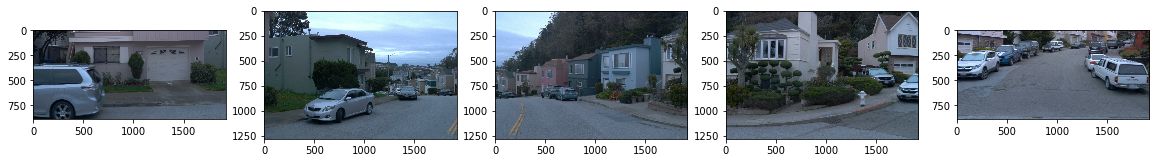

In [70]:
## PURE IMAGES


# Load data and check what you have

with open("myframe.pickle", "rb") as f:
    myframes = pickle.load(f)
    

first_frame = myframes.images[-1]
    
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 1
order = [2,1,0,3,4]
for i in range(1, columns*rows +1):
    img = first_frame[order[i-1]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

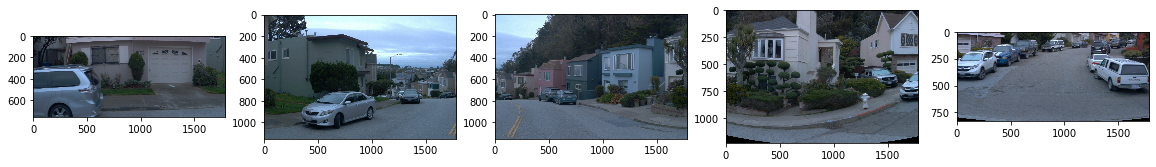

In [71]:
## CYLINDRICAL WARPED IMAGES

fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 1
order = [2,1,0,3,4]
cyl_imgs = []

for i in range(1, columns*rows +1):
    img = first_frame[order[i-1]]
    h, w = img.shape[:2]
    intrinsics = myframes.camera_calibrations[order[i-1]+1][0]
    K = np.array([[intrinsics[0],0,intrinsics[2]],[0,intrinsics[1],intrinsics[3]],[0,0,1]]) # mock intrinsics
    img_cyl = cylindricalWarp(img, K)
    img_cyl = border_searcher(img_cyl)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_cyl)
    cyl_imgs.append(img_cyl)
plt.show()

In [72]:
def merge2(img1, img2):
    (kps1, des1) = detectAndDescribe(img1, method = 'sift')
    (kps2, des2) = detectAndDescribe(img2, method = 'sift')
    bf = createMatcher('sift', False)

    # Match descriptors.
    matches = bf.knnMatch(des1,des2, k=2)


    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1,kps1,img2,kps2,good,None, flags=2)

    src_pts = np.float32([ kps1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kps2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    width = (img2.shape[1] + img1.shape[1] )
    height = max(img2.shape[0] , img1.shape[0])

    im_dst = cv2.warpPerspective(img1, M, (width, height))
    
    nim = im_dst

    #for i in range(im_dst.shape[0]):
    #    for j in range(im_dst.shape[1]):
    #        nim[i][j] = im_dst[i][j]
    #        if sum(im_dst[i][j]) == 0:
    #            if i < img2.shape[0] and j < img2.shape[1]:
    #                nim[i][j] = img2[i][j]
    
    nim[:img2.shape[0], :img2.shape[1], :] = img2

    return nim

In [73]:
def merge5(cyl_imgs):
    im43 = merge2(cyl_imgs[4],cyl_imgs[3])
    im10 = flp(merge2(flp(cyl_imgs[0]),flp(cyl_imgs[1])))
    center_and_left = flp(merge2(flp(im10), flp(cyl_imgs[2])))
    center_and_left_and_right = merge2(im43, center_and_left)
    return center_and_left_and_right
def merge3(cyl_imgs):

    center_and_left = flp(merge2(flp(cyl_imgs[1]), flp(cyl_imgs[2])))
    
    center_and_left_and_right = merge2(cyl_imgs[3], center_and_left)
    return center_and_left_and_right

## Cyllindrical warp before stitching

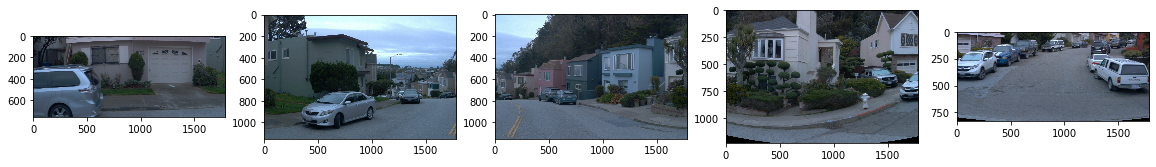

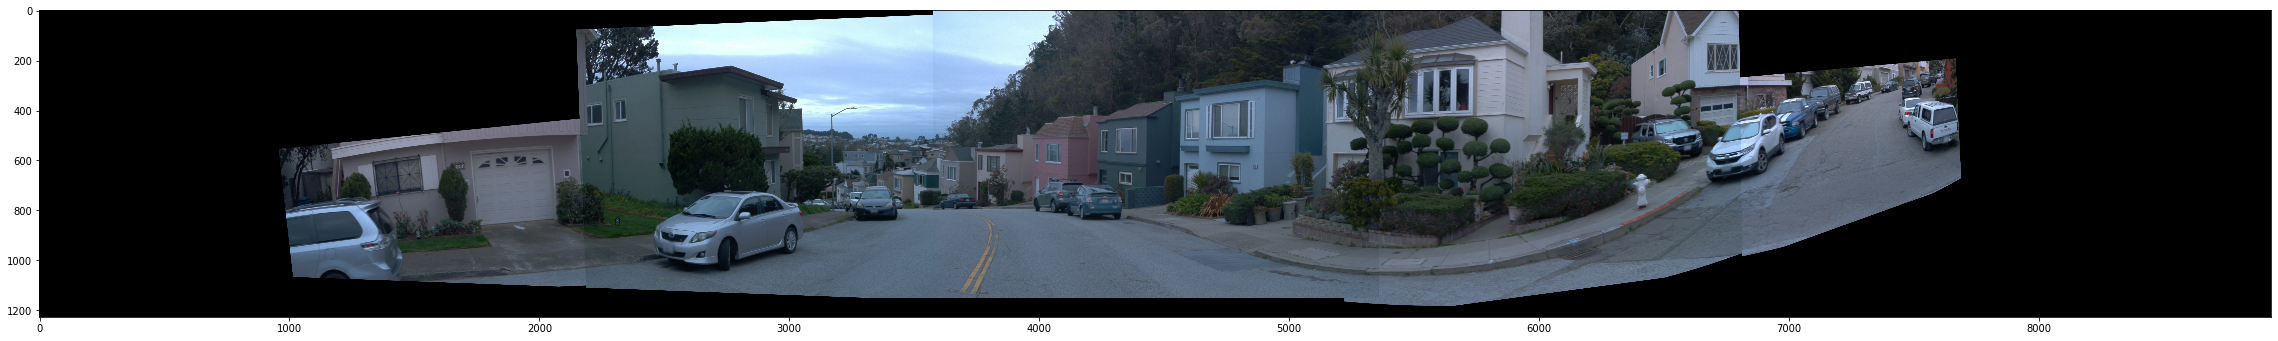

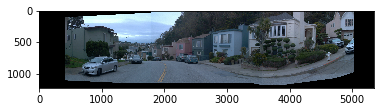

In [74]:


fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 1
order = [2,1,0,3,4]
cyl_imgs = []

for i in range(1, columns*rows +1):
    img = first_frame[order[i-1]]
    h, w = img.shape[:2]
    intrinsics = myframes.camera_calibrations[order[i-1]+1][0]
    extrinsics = myframes.camera_calibrations[order[i-1]+1][1]
    K = np.array([[intrinsics[0],0,intrinsics[2]],[0,intrinsics[1],intrinsics[3]],[0,0,1]]) # mock intrinsics
    E = np.array(extrinsics).reshape((4,4))
    img_cyl = cylindricalWarp(img, K)
    img_cyl = border_searcher(img_cyl)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_cyl)
    cyl_imgs.append(img_cyl)
plt.show()
fig=plt.figure(figsize=(40, 20))
im5 = merge5(cyl_imgs)
plt.imshow(im5)
plt.show()
im3 = merge3(cyl_imgs)
plt.imshow(im3)

## No cyllindrical warp before stitching

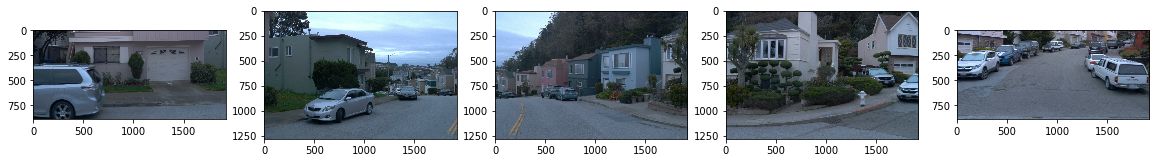

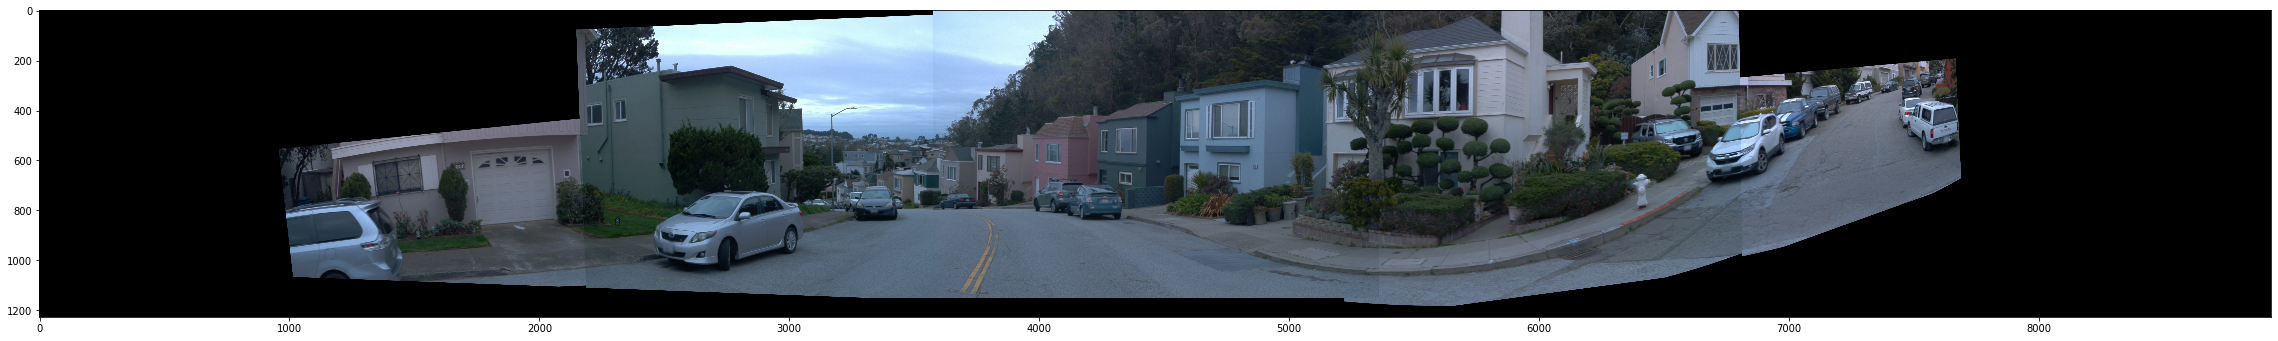

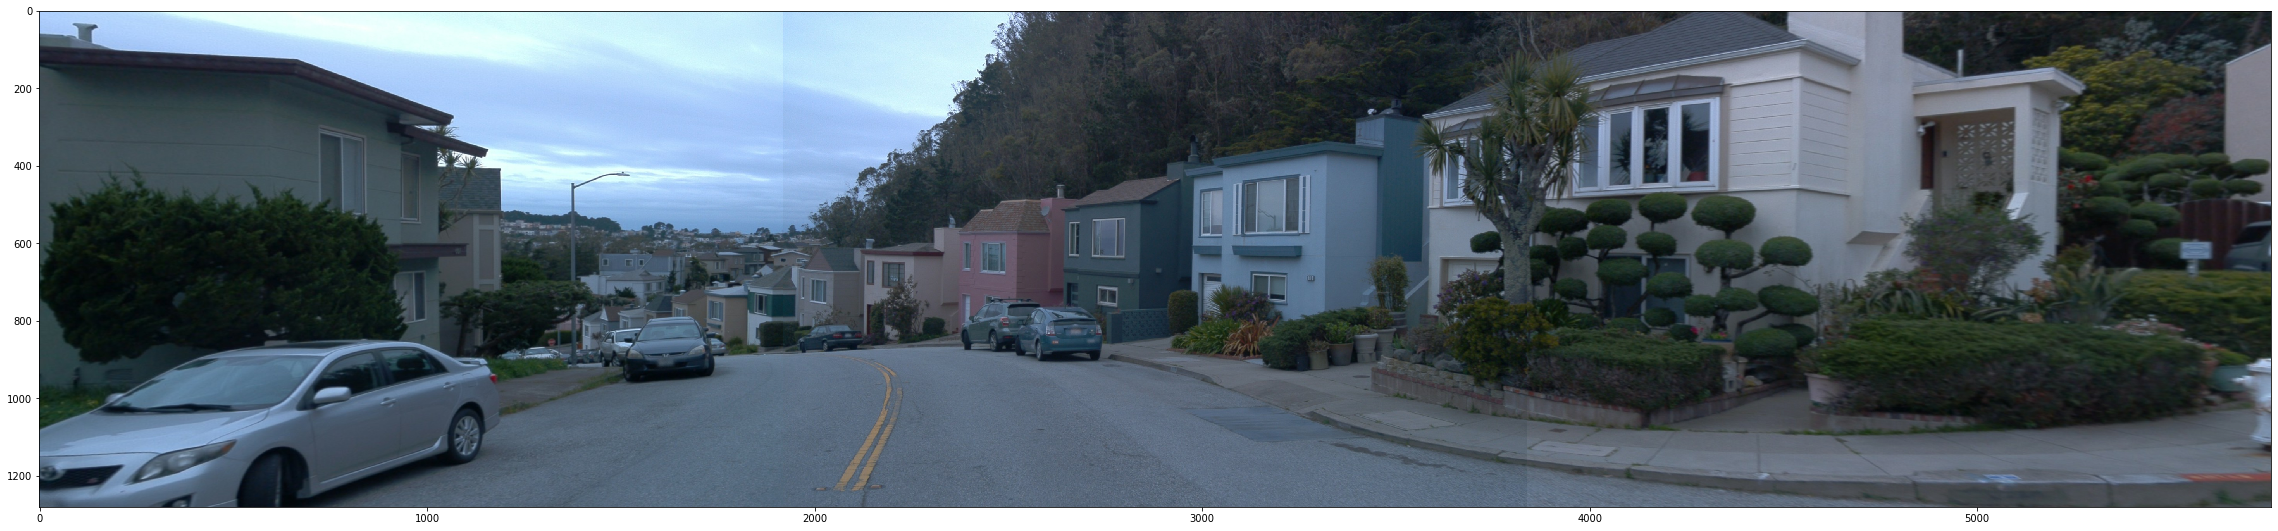

In [75]:
## PURE IMAGES

    
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 1
order = [2,1,0,3,4]
pure_images = []

for i in range(1, columns*rows +1):
    img = first_frame[order[i-1]]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    pure_images.append(img)
plt.show()
fig=plt.figure(figsize=(40, 20))
im5 = merge5(cyl_imgs)
plt.imshow(im5)
plt.show()

fig=plt.figure(figsize=(40, 20))
im5 = merge3(pure_images)
plt.imshow(im5)

# Extrinsics and intrinsics

In [76]:
# Pretty print
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [77]:
image_id = 1
#    FRONT = 1;
#    FRONT_LEFT = 2;
#    FRONT_RIGHT = 3;
#    SIDE_LEFT = 4;
#    SIDE_RIGHT = 5;


# EXTRINSICS

## 4x4 row major transform matrix that tranforms 3d points from one frame to another.

extrinsics = myframes.camera_calibrations[image_id][1]


# INTRINSICS

# 1d Array of [f_u, f_v, c_u, c_v, k{1, 2}, p{1, 2}, k{3}].
# Note that this intrinsic corresponds to the images after scaling.
# Camera model: pinhole camera.
# Lens distortion:
#   Radial distortion coefficients: k1, k2, k3.
#   Tangential distortion coefficients: p1, p2.
# k_{1, 2, 3}, p_{1, 2} follows the same definition as OpenCV.

intrinsics = myframes.camera_calibrations[image_id][0]

In [78]:
E = np.array(extrinsics).reshape((4,4))

K = np.array([[intrinsics[0],0,intrinsics[2]],[0,intrinsics[1],intrinsics[3]],[0,0,1]])

In [79]:
# The extrinsics matrix takes a [xc, yc, zc, 1] point from camera coordinates to vehicle frame coordinates

# i.e. [x, y, z]_world = E [xc, yc, zc, 1]
print(E)

[[ 0.99998  0.00456 -0.00459  1.53937]
 [-0.00456  0.99999  0.00073 -0.02369]
 [ 0.0046  -0.00071  0.99999  2.11601]
 [ 0.       0.       0.       1.     ]]


In [80]:
print(K)

[[2060.14259    0.       975.59651]
 [   0.      2060.14259  630.85333]
 [   0.         0.         1.     ]]


In [81]:
E[:-1,:-1] # rotation matrix

array([[ 0.99998,  0.00456, -0.00459],
       [-0.00456,  0.99999,  0.00073],
       [ 0.0046 , -0.00071,  0.99999]])